In [ ]:
#!pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

sns.set_theme(style="darkgrid")



### Goals:
#### Work in progress 
    
      - Average distance per month (all modalities).
      - Average moving time;
      - Group by type.
      - Historical series by year.
      - Average of average averages
      - Average of the maximum changes.
      - Average elevations (high and low).
      - Time Series

In [2]:
files = ['./data/response1.json', './data/response2.json', './data/response3.json', './data/response4.json', './data/response5.json', './data/response6.json']

In [3]:
dataframes = [pd.read_json(f) for f in files]

In [4]:
df = pd.concat(dataframes)

In [5]:
df.head()

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,...,has_heartrate,average_heartrate,max_heartrate,heartrate_opt_out,display_hide_heartrate_option,elev_high,elev_low,pr_count,total_photo_count,has_kudoed
0,2,"{'id': 31401271, 'resource_state': 1}",Passeio para o norte.,69263.4,8983,9205,221.0,Ride,10.0,5306688462,...,True,122.2,178.0,False,True,31.0,-14.0,13,1,False
1,2,"{'id': 31401271, 'resource_state': 1}",Afternoon Run,6249.2,2160,2164,48.0,Run,NaN,5297612077,...,True,163.6,180.0,False,True,329.0,-69.0,0,0,False
2,2,"{'id': 31401271, 'resource_state': 1}",Morning Ride,31979.3,4390,4438,84.0,Ride,NaN,5294909081,...,True,142.5,180.0,False,True,30.0,1.0,0,0,False
3,2,"{'id': 31401271, 'resource_state': 1}",Afternoon Run,3814.5,1206,1337,47.0,Run,NaN,5289199665,...,True,160.3,180.0,False,True,-11.0,-41.0,0,0,False
4,2,"{'id': 31401271, 'resource_state': 1}",Morning Run,7421.4,2382,2382,80.0,Run,0.0,5256094139,...,False,NaN,NaN,False,False,33.0,1.0,4,0,False


In [6]:
df.shape

(167, 53)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 16
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resource_state                 167 non-null    int64  
 1   athlete                        167 non-null    object 
 2   name                           167 non-null    object 
 3   distance                       167 non-null    float64
 4   moving_time                    167 non-null    int64  
 5   elapsed_time                   167 non-null    int64  
 6   total_elevation_gain           167 non-null    float64
 7   type                           167 non-null    object 
 8   workout_type                   143 non-null    float64
 9   id                             167 non-null    int64  
 10  external_id                    167 non-null    object 
 11  upload_id                      167 non-null    int64  
 12  start_date                     167 non-null    obje

In [8]:
#interessing columns

In [9]:
columns=['distance', 'moving_time','elapsed_time', 'type', 'start_date', 'average_speed', 'max_speed']

In [10]:
# base ride

In [11]:
base_ride = df.copy()
base_ride = base_ride.loc[base_ride['type']== 'Ride']
base_ride = base_ride[columns]

In [12]:
#base run

In [13]:
base_run = df.copy()
base_run = base_run.loc[base_run['type']== 'Run']
base_run = base_run[columns]

In [14]:
# transform column datetime -> date

In [15]:
def transform_data(date1):
    datee=''
    date_t = parser.parse(date1)
    datee = date_t.date()
    return str(datee)

In [16]:
base_ride['start_date'] = base_ride['start_date'].apply(lambda x: transform_data(x))
base_run['start_date'] = base_run['start_date'].apply(lambda x: transform_data(x))

In [17]:
base_ride.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,118.0,37318.038136,24985.196543,3.4,22111.37500,31705.3000,39867.35000,146620.000
moving_time,118.0,5525.830508,3475.180458,0.0,3488.00000,4408.0000,6086.75000,18916.000
elapsed_time,118.0,6982.101695,7788.498433,0.0,3842.75000,4784.0000,7136.75000,77760.000
average_speed,118.0,6.650737,1.047427,0.0,6.05125,6.6855,7.16475,8.858
max_speed,118.0,13.830508,2.759583,0.6,12.02500,13.8000,15.47500,23.800


In [18]:
base_run.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,48.0,4609.622917,2269.505804,0.0,2918.42500,4513.500,6103.0000,10128.900
moving_time,48.0,2043.479167,1621.000072,0.0,1232.25000,1693.000,2278.5000,9516.000
elapsed_time,48.0,2829.687500,2725.616738,0.0,1526.00000,2167.500,3112.0000,16420.000
average_speed,48.0,2.588646,0.766591,0.0,2.00625,2.882,3.1295,3.681
max_speed,48.0,5.181250,1.932329,0.0,4.17500,4.750,5.4500,12.800


In [19]:
# generating date in the index

In [22]:
base_ride.index, base_run.index = pd.to_datetime(base_ride['start_date']), pd.to_datetime(base_run['start_date'])


In [23]:
base_ride['day'], base_run['day'] = base_ride.index.day, base_run.index.day
base_ride['month'], base_run['month'] = base_ride.index.month, base_run.index.month
base_ride['year'], base_run['year'] = base_ride.index.year, base_run.index.year
base_ride['day_off_week'], base_run['day_of_week'] = base_ride.index.dayofweek, base_run.index.dayofweek

In [24]:
month_desc={
    1: 'january',
    2: 'february',
    3: 'march',
    4: 'april',
    5: 'may',
    6: 'june',
    7: 'july',
    8: 'august',
    9: 'september',
    10: 'octuber',
    11: 'november',
    12: 'december'
}

week={
   - 0: 'monday',
   - 1: 'tuesday',
   - 2: 'wednesday',
   - 3: 'thursday',
   - 4: 'friday',
   - 5: 'saturday',
   - 6: 'sunday'
}

In [26]:
base_ride['month'].replace(month_desc, inplace=True)
base_run['month'].replace(month_desc, inplace=True)

In [27]:
base_ride.sort_index(inplace=True)
base_ride.head()

,distance,moving_time,elapsed_time,type,start_date,average_speed,max_speed,day,month,year,day_off_week
start_date,,,,,,,,,,,
2018-11-11,16816.5,2784,2964,Ride,2018-11-11,6.040,10.2,11,november,2018,6
2019-01-21,31427.4,5062,6223,Ride,2019-01-21,6.208,12.4,21,january,2019,0
2019-01-22,35112.2,6855,11197,Ride,2019-01-22,5.122,14.5,22,january,2019,1
2019-01-24,32771.4,5733,12063,Ride,2019-01-24,5.716,11.1,24,january,2019,3
2019-01-26,60176.3,9822,11270,Ride,2019-01-26,6.127,11.4,26,january,2019,5


In [28]:
base_run.sort_index(inplace=True)
base_run.head()

,distance,moving_time,elapsed_time,type,start_date,average_speed,max_speed,day,month,year,day_of_week
start_date,,,,,,,,,,,
2018-11-06,0.0,0,0,Run,2018-11-06,0.000,0.0,6,november,2018,1
2018-11-09,7800.9,4095,5172,Run,2018-11-09,1.905,4.7,9,november,2018,4
2018-11-10,7952.5,4329,4870,Run,2018-11-10,1.837,5.4,10,november,2018,5
2019-01-28,4730.7,1874,2415,Run,2019-01-28,2.524,5.6,28,january,2019,0
2019-02-02,3595.2,1376,1674,Run,2019-02-02,2.613,5.6,2,february,2019,5


In [29]:
## analysis


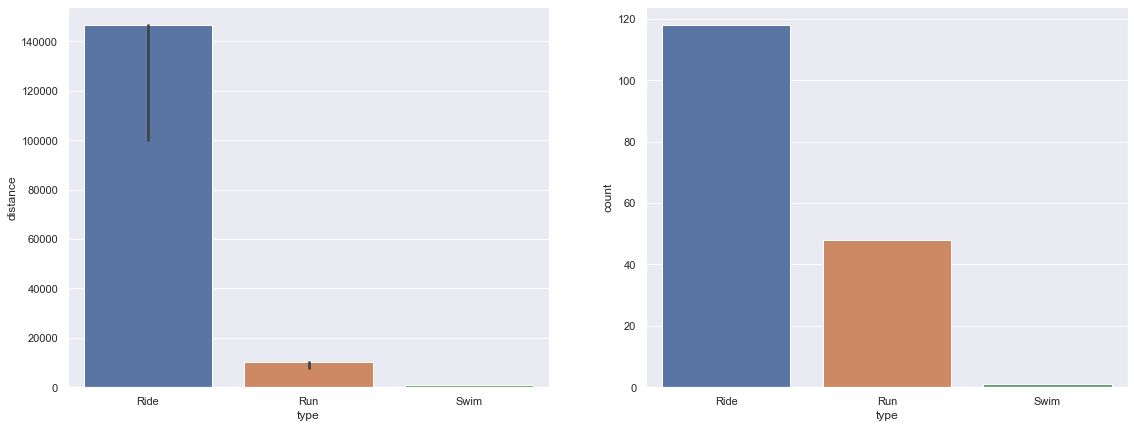

In [32]:
#distance X type and count X type
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(19, 7))
sns.barplot(x='type', y='distance', data=df, ax=axis1, estimator=max)
sns.countplot(x='type', data=df, ax=axis2);

### run

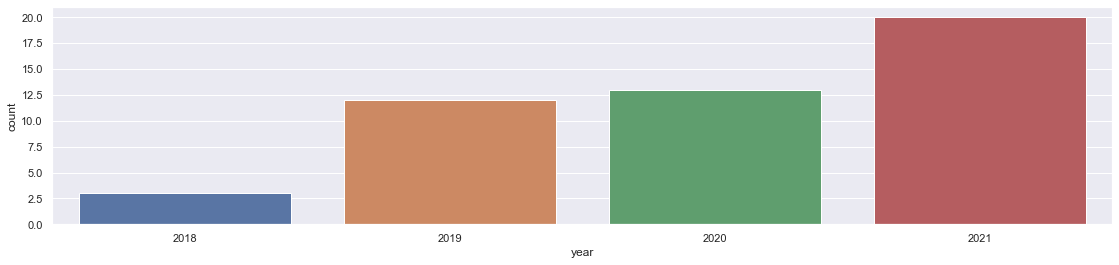

In [33]:
fig, (axis1) = plt.subplots(1, figsize=(19,4))
sns.countplot(x='year', data=base_run, ax=axis1);

In [34]:
# distance per month x year

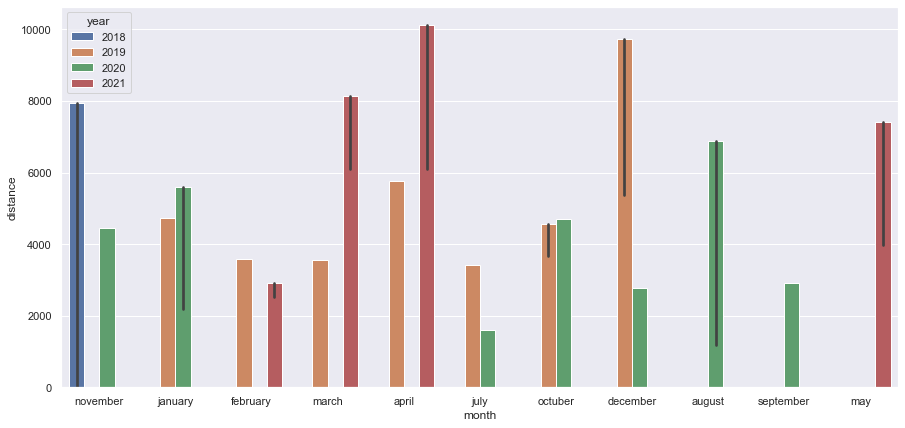

In [36]:
fig, (axis1) = plt.subplots(1, figsize=(15,7))
ax = sns.barplot(x="month", y="distance", data=base_run, estimator=np.max, orient='v', hue='year')


In [40]:
#sum run per month x year 2021 

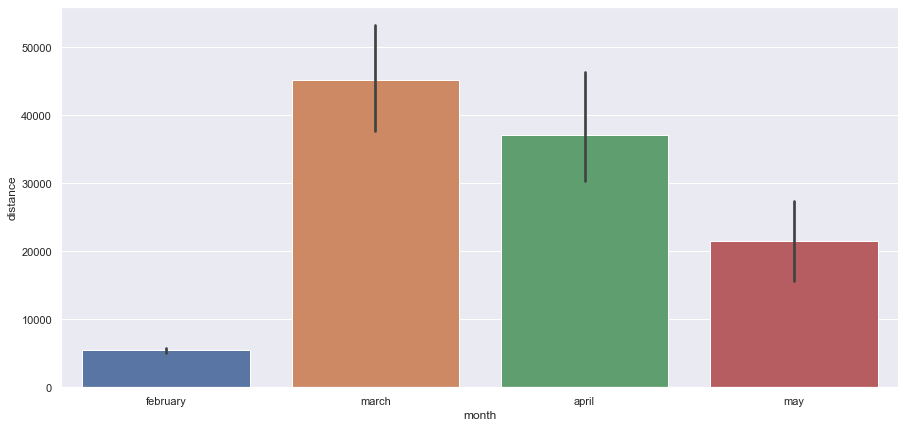

In [41]:
m2021 = base_run.loc[base_run['year'] == 2021]
fig, (axis1) = plt.subplots(1, figsize=(15,7))
ax = sns.barplot(x="month", y="distance", data=m2021, estimator=np.sum, orient='v')

In [42]:
# distance per day x month x year 2021

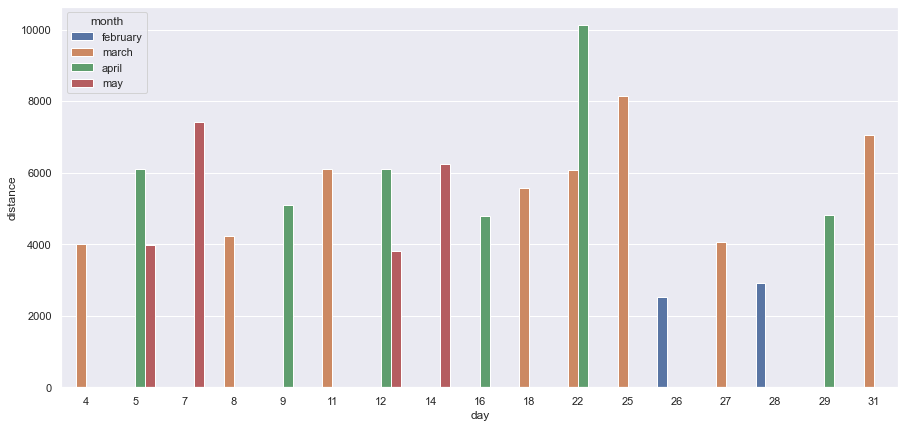

In [43]:
fig, (axis1) = plt.subplots(1, figsize=(15,7))
axis1 = sns.barplot(ax=axis1, x="day", y="distance", data=m2021, estimator=np.max, orient='v', hue='month')

In [53]:
#avg x distance 2021

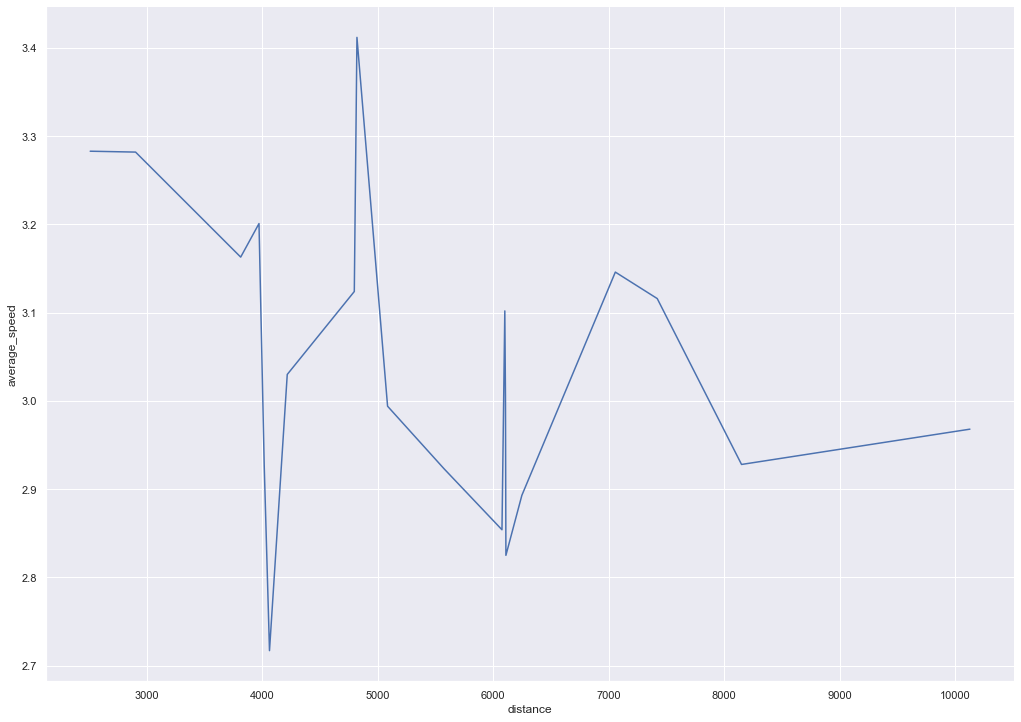

In [46]:
sns.relplot(x="distance", y="average_speed", kind="line",height=10, aspect=11.7/8.27, data=m2021);

### ride

In [47]:
#count ride

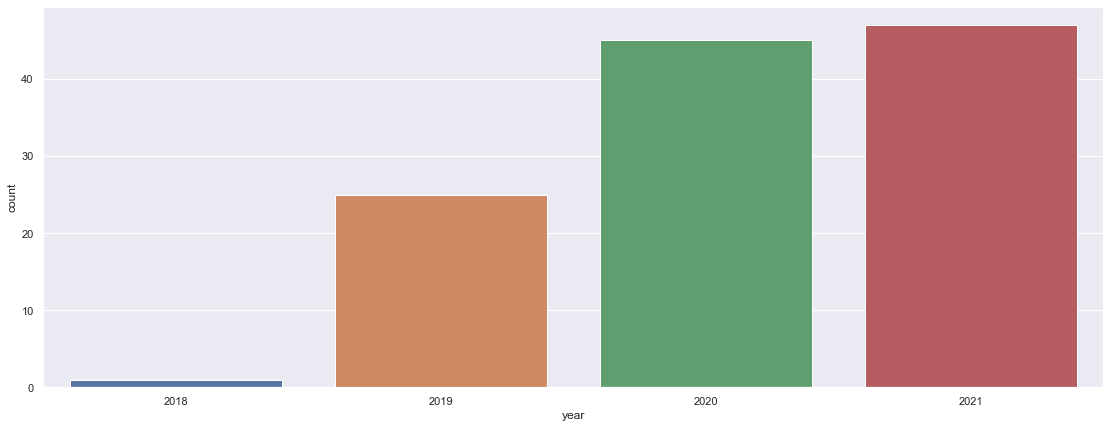

In [49]:
fig, (axis1) = plt.subplots(1, figsize=(19,7))
sns.countplot(x='year', data=base_ride, ax=axis1);

In [57]:
# distance sum per month x year

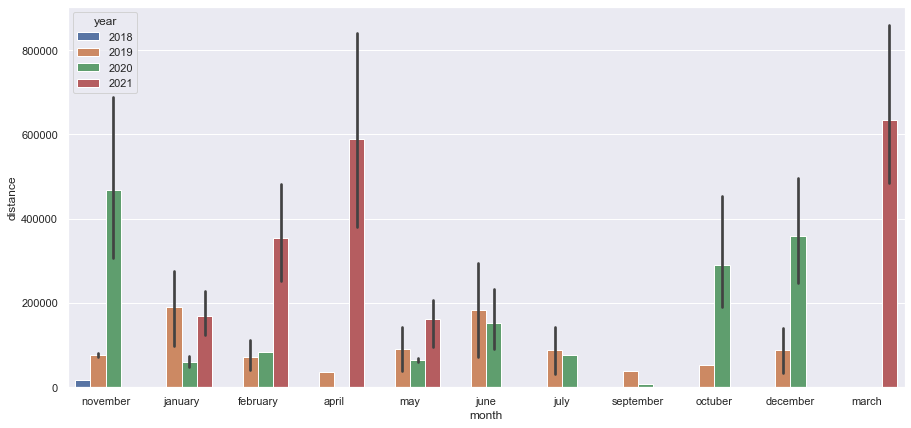

In [52]:
fig, (axis1) = plt.subplots(1, figsize=(15,7))
ax = sns.barplot(x="month", y="distance", data=base_ride, estimator=np.sum, orient='v', hue='year')


In [55]:
#count ride per month x year 2021 

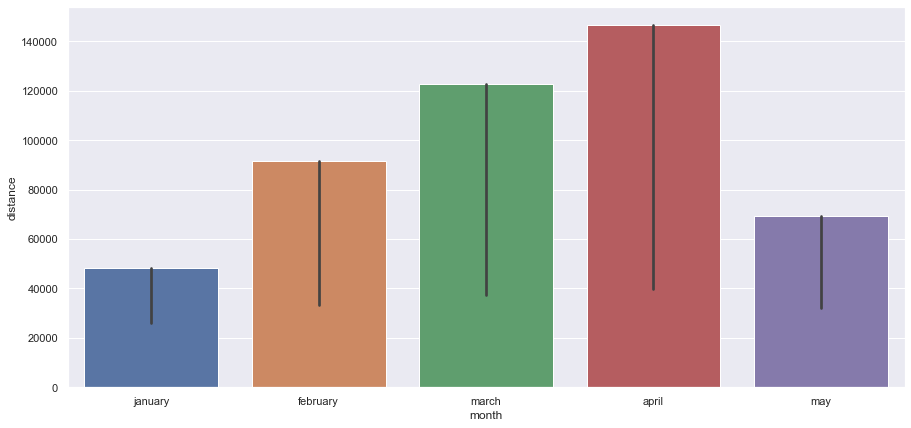

In [56]:
r2021 = base_ride.loc[base_ride['year'] == 2021]
fig, (axis1) = plt.subplots(1, figsize=(15,7))
ax = sns.barplot(x="month", y="distance", data=r2021, estimator=np.max, orient='v')

In [58]:
# distance per day x month x year 2021

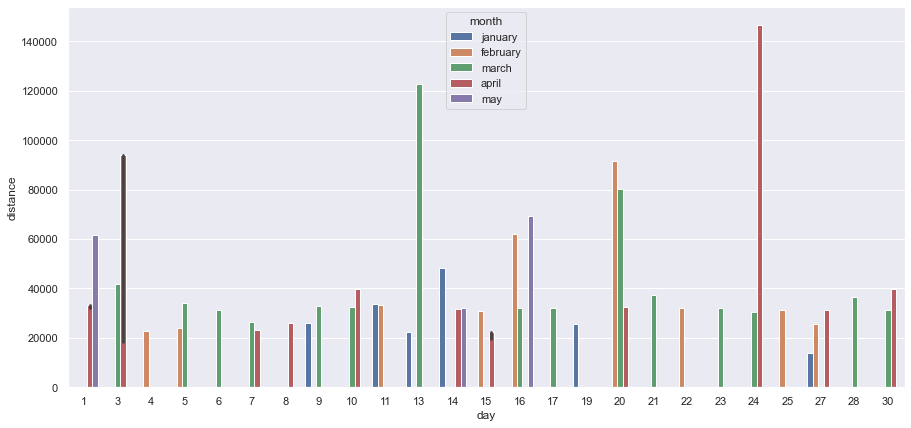

In [59]:
fig, (axis1) = plt.subplots(1, figsize=(15,7))
axis1 = sns.barplot(ax=axis1, x="day", y="distance", data=r2021, estimator=np.max, orient='v', hue='month')

In [61]:
# avg x distance

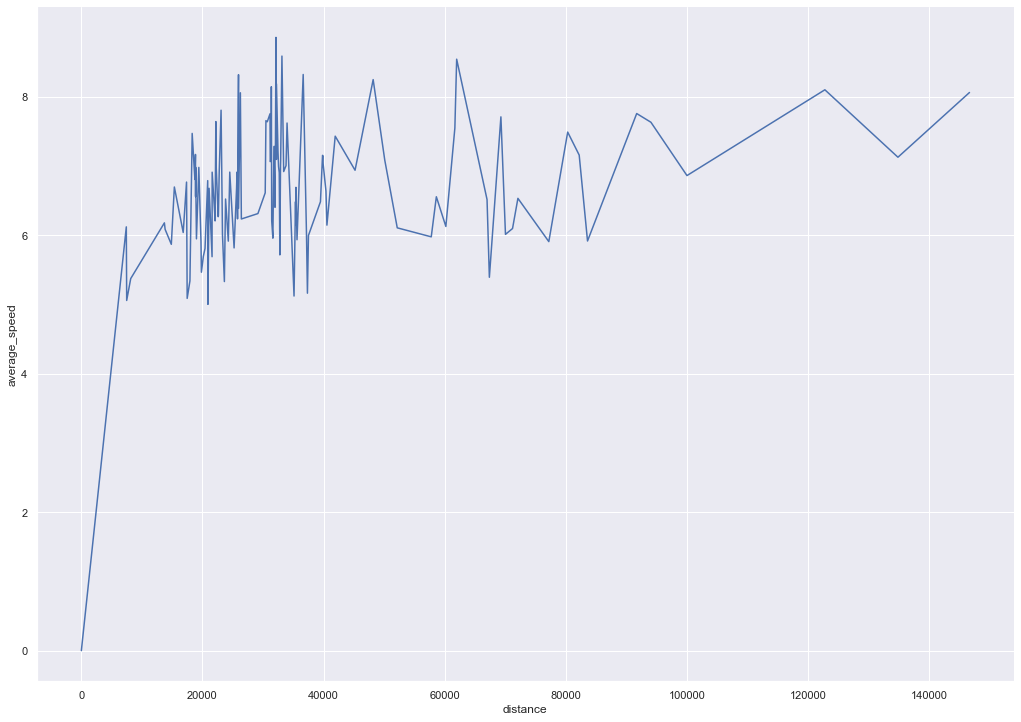

In [60]:
sns.relplot(x="distance", y="average_speed", kind="line",height=10, aspect=11.7/8.27, data=base_ride);

## time series 


### Run

In [64]:
run_time_series = base_run['distance']
run_time_series.sort_index(inplace=True)
run_time_series

start_date
2018-11-06        0.0
2018-11-09     7800.9
2018-11-10     7952.5
2019-01-28     4730.7
2019-02-02     3595.2
2019-03-23     3560.9
2019-04-27     5777.3
2019-07-19     3414.6
2019-10-06     4562.5
2019-10-28     3668.0
2019-12-03     3582.9
2019-12-07     6958.1
2019-12-12     2750.3
2019-12-18     5365.6
2019-12-23     9744.2
2020-01-08     5594.0
2020-01-16      582.4
2020-01-18     2190.2
2020-01-25     1402.6
2020-01-25     1831.6
2020-01-31     2498.4
2020-07-03     1587.9
2020-08-01     6884.2
2020-08-18     1181.4
2020-09-22     2923.1
2020-10-14     4698.1
2020-11-24     4464.5
2020-12-10     2768.4
2021-02-26     2511.3
2021-02-28     2904.4
2021-03-04     4018.2
2021-03-08     4217.7
2021-03-11     6111.0
2021-03-18     5576.2
2021-03-22     6077.0
2021-03-25     8151.4
2021-03-27     4063.9
2021-03-31     7058.6
2021-04-05     6107.2
2021-04-09     5086.4
2021-04-12     6101.6
2021-04-16     4798.3
2021-04-22    10128.9
2021-04-29     4821.2
2021-05-05     3973.0

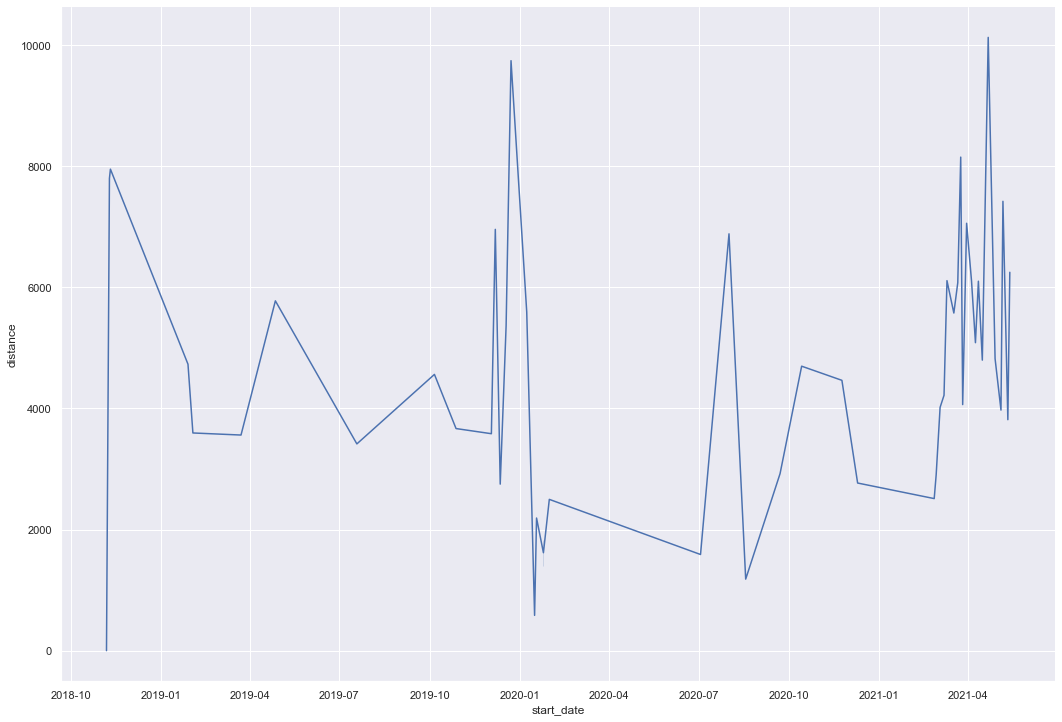

In [65]:
sns.relplot(kind="line",height=10, aspect=10.7/7.27, data=run_time_series);

In [66]:
#tm per year

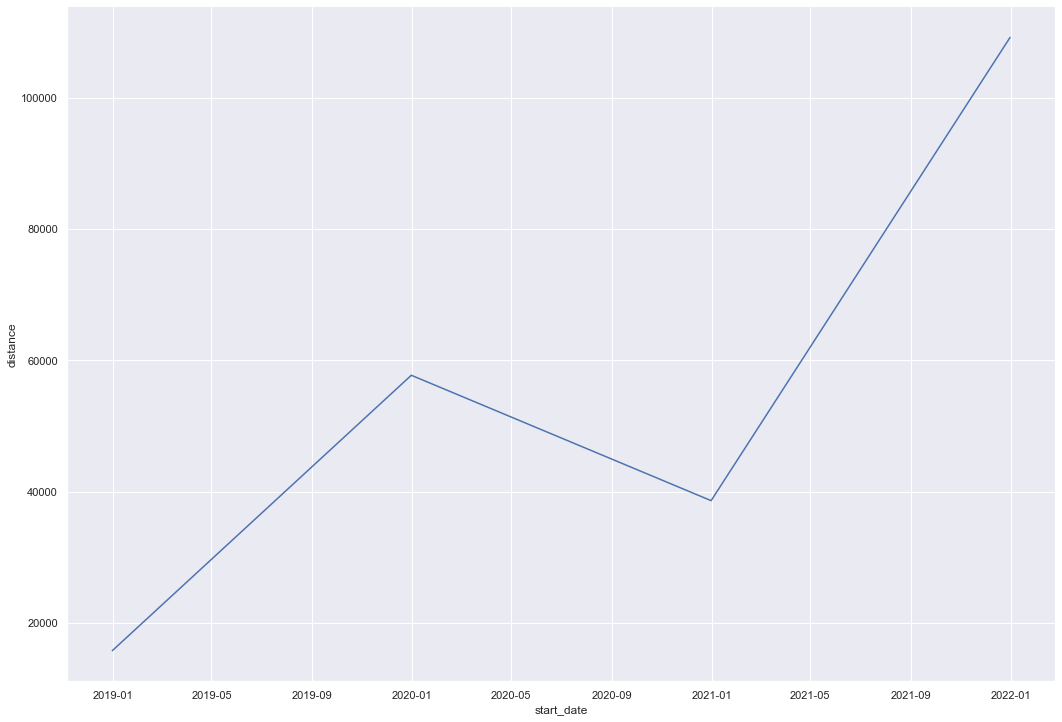

In [69]:
run_tm_year = run_time_series.resample('Y').sum()
sns.relplot(kind="line",height=10, aspect=10.7/7.27, data=run_tm_year);

In [132]:
run_train = run_time_series[:round(len(run_time_series)*0.90)]
run_train.shape

(43,)

In [133]:
run_test = run_time_series[round(len(run_time_series)*0.90):]
run_test.shape

(5,)

# Arima -> ride x run

In [134]:
from pmdarima.arima import ADFTest

In [135]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(run_time_series)

(0.23652188605339164, True)

In [152]:
run_model = auto_arima(run_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                       start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12,  
                       seasonal=True, error_action='warn', trace=True, suppress_warnings=True, 
                       stepwise=True, random_state=18)
run_model.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=581.266, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=562.946, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=572.233, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=558.684, Time=1.09 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=557.665, Time=2.49 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=7.49 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=4.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=8.66 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=559.149, Time=3.52 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=559.379, Time=7.23 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=557.774, Time=2.40 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=559.766, Time=

(1, 1, 0)

In [137]:
run_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -273.832
Date:                            Mon, 17 May 2021   AIC                            557.665
Time:                                    17:27:07   BIC                            564.671
Sample:                                         0   HQIC                           559.906
                                             - 43                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4560      0.218     -2.091      0.037      -0.883      -0.029
ar.S.L12      -1.2252      0.327     -3.748      0.000      -1.866      -0.585
ar.S.L24      -1.1142      0.388     -2.870      0.004      -1.875      -0.353
ar.S.L36      -0.6071      0.296     -2.054      0.040      -1.186      -0.028
sigma2      2.862e+06   1.74e+06      1.645      0.100   -5.48e+05    6.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.60   Prob(JB):                         0.98
Heteroskedasticity (H):               1.17   Skew:                             0.03
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
run_predict = run_model.predict(n_periods=len(run_test))
run_predict

array([7116.61865229, 8338.3889373 , 7557.51670074, 8358.97865977,
       8895.6092002 ])

In [139]:
#predict

In [140]:
run_prediction = pd.DataFrame(run_model.predict(n_periods=len(run_test)), index=run_test.index)
run_prediction.columns = ['distance_predict']
run_prediction

,distance_predict
start_date,
2021-04-29,7116.618652
2021-05-05,8338.388937
2021-05-07,7557.516701
2021-05-12,8358.978660
2021-05-14,8895.609200


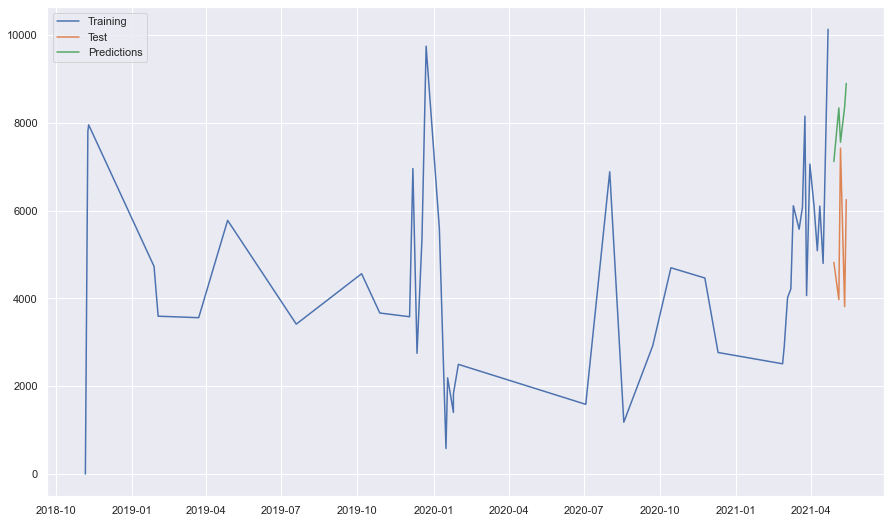

In [141]:
plt.figure(figsize=(15,9))
plt.plot(run_train, label = 'Training')
plt.plot(run_test, label = 'Test')
plt.plot(run_prediction, label = 'Predictions')
plt.legend();

In [142]:
run_yvspred = pd.DataFrame({
    'y_test': run_test,
    'pred': run_prediction['distance_predict']
})

run_yvspred.head()

,y_test,pred
start_date,,
2021-04-29,4821.2,7116.618652
2021-05-05,3973.0,8338.388937
2021-05-07,7421.4,7557.516701
2021-05-12,3814.5,8358.978660
2021-05-14,6249.2,8895.609200


## ride

In [143]:
ride_time_series = base_ride['distance']
ride_time_series.sort_index(inplace=True)
ride_time_series

start_date
2018-11-11    16816.5
2019-01-21    31427.4
2019-01-22    35112.2
2019-01-24    32771.4
2019-01-26    60176.3
               ...   
2021-04-27    31340.1
2021-04-30    39816.8
2021-05-01    61663.6
2021-05-14    31979.3
2021-05-16    69263.4
Name: distance, Length: 118, dtype: float64

In [144]:
#tm distance

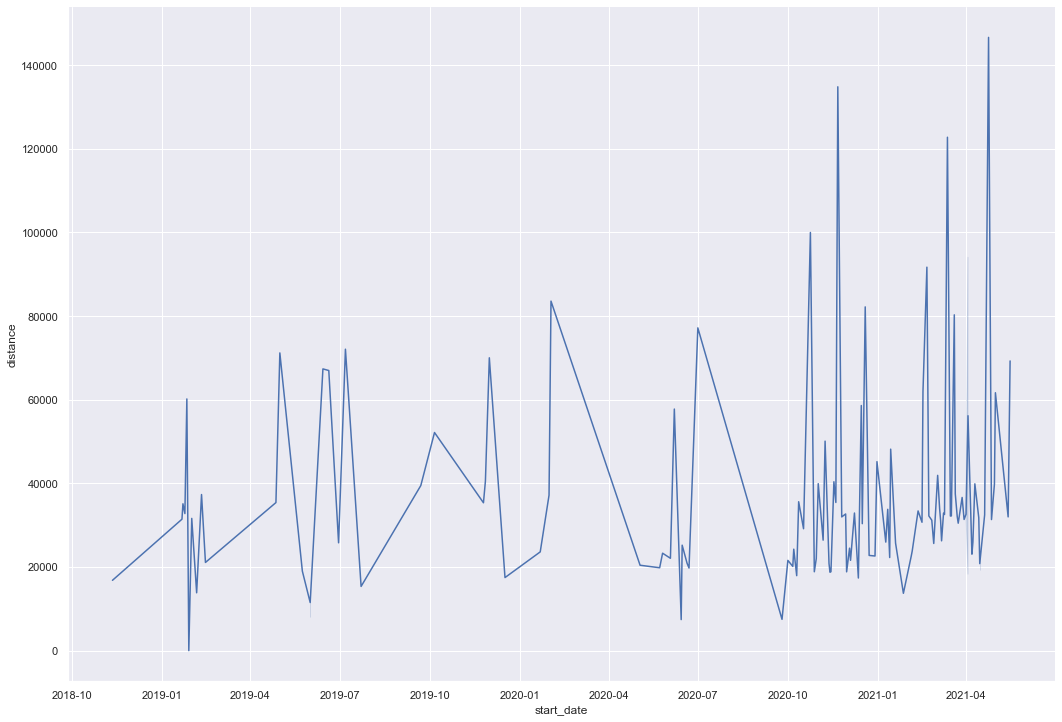

In [94]:
sns.relplot(kind="line",height=10, aspect=10.7/7.27, data=ride_time_series);

In [145]:
#tm distance year

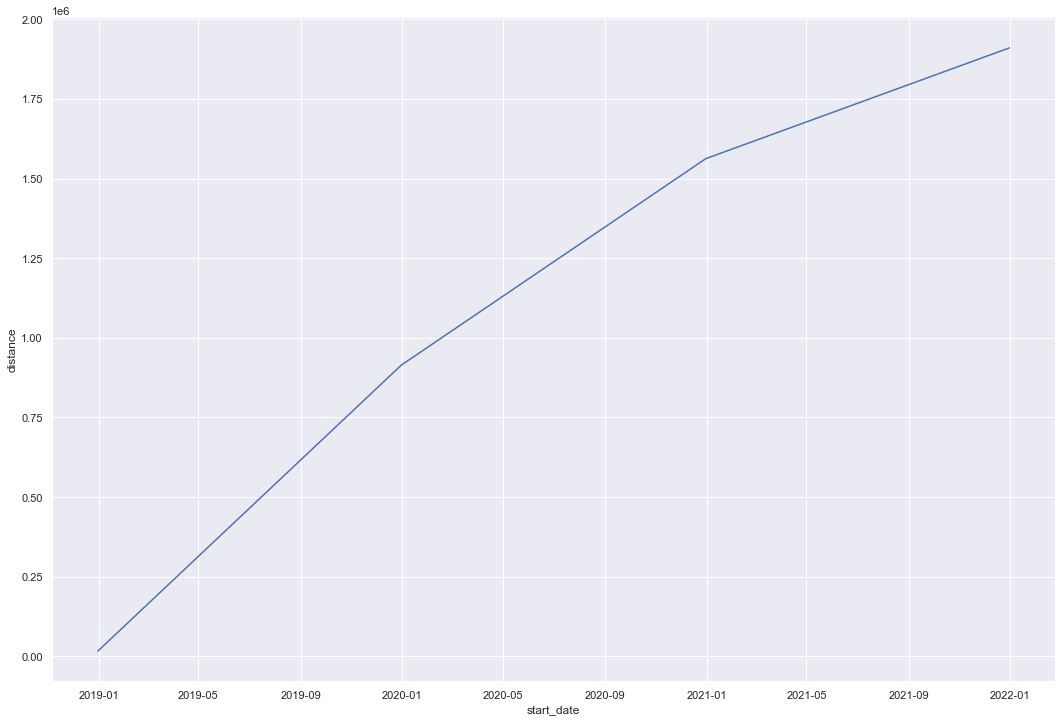

In [95]:
ride_tm_year = ride_time_series.resample('A').sum()
sns.relplot(kind="line",height=10, aspect=10.7/7.27, data=ride_tm_year);

In [146]:
#tm distance month

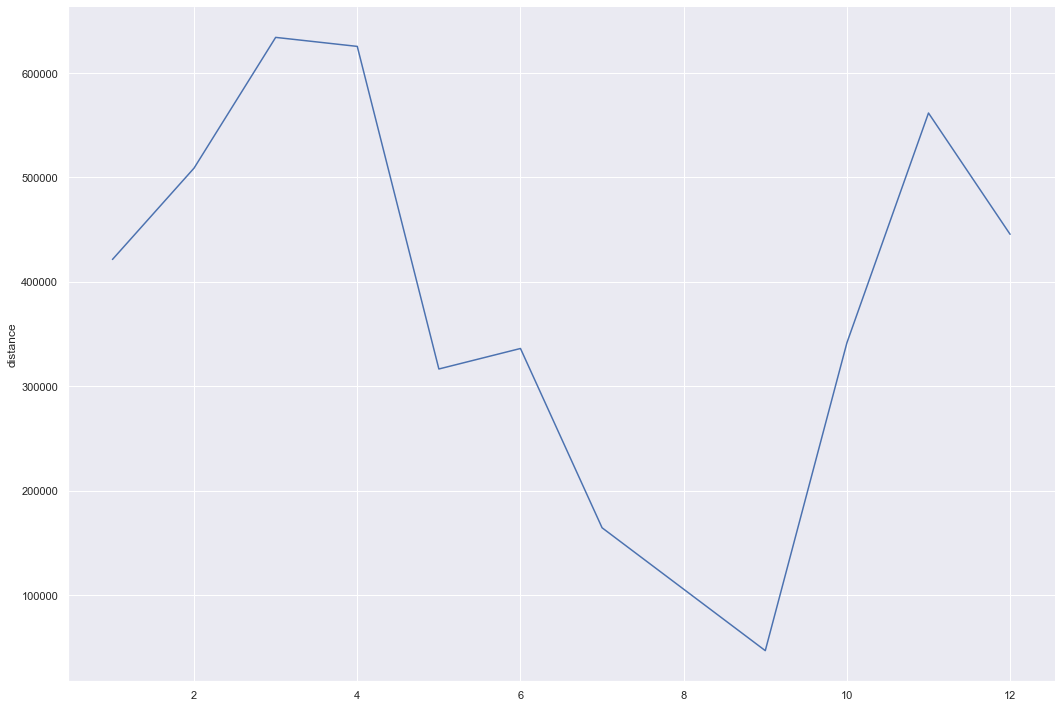

In [147]:
ride_tm_month = ride_time_series.groupby([lambda x: x.month]).sum()
sns.relplot(kind="line", height=10, aspect=10.7/7.27, data=ride_tm_month);

In [150]:
#split train x test

In [148]:
ride_train = ride_time_series[:round(len(ride_time_series)*0.90)]
ride_train.shape

(106,)

In [149]:
ride_test = ride_time_series[round(len(ride_time_series)*0.90):]
ride_test.shape

(12,)

In [124]:
#arima

In [125]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(ride_time_series)

(0.01, False)

In [126]:
ride_model = auto_arima(ride_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                       start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,
                       error_action='warn', trace=True, suppress_warnings=True, 
                       stepwise=True, random_state=18)
ride_model.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2277.440, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2221.890, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2189.150, Time=0.63 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2210.972, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2190.894, Time=1.00 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2174.462, Time=4.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2192.891, Time=1.91 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2192.876, Time=1.97 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=10.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2242.763, Time=0.76 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2191.312, Time=1.59 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2187.988, Time=1.50 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2216.210, Time=0.67 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=2186.306, Time=3.64 sec
 ARIMA(0,1,1)(0,1,2)[12

(0, 1, 1)

In [153]:
#predict

In [127]:
ride_predict = ride_model.predict(n_periods=len(ride_test))
ride_predict

array([52700.90565774, 47368.12975243, 38478.38512167, 34198.59702211,
       42679.72547387, 42685.07101124, 42099.02550408, 35024.88624206,
       38649.58746663, 39145.2332656 , 62945.30718556, 52537.18223709])

In [128]:
ride_prediction = pd.DataFrame(ride_model.predict(n_periods=len(ride_test)), index=ride_test.index)
ride_prediction.columns = ['distance_predict']
ride_prediction

,distance_predict
start_date,
2021-04-08,52700.905658
2021-04-10,47368.129752
2021-04-14,38478.385122
2021-04-15,34198.597022
2021-04-15,42679.725474
2021-04-20,42685.071011
2021-04-24,42099.025504
2021-04-27,35024.886242
2021-04-30,38649.587467


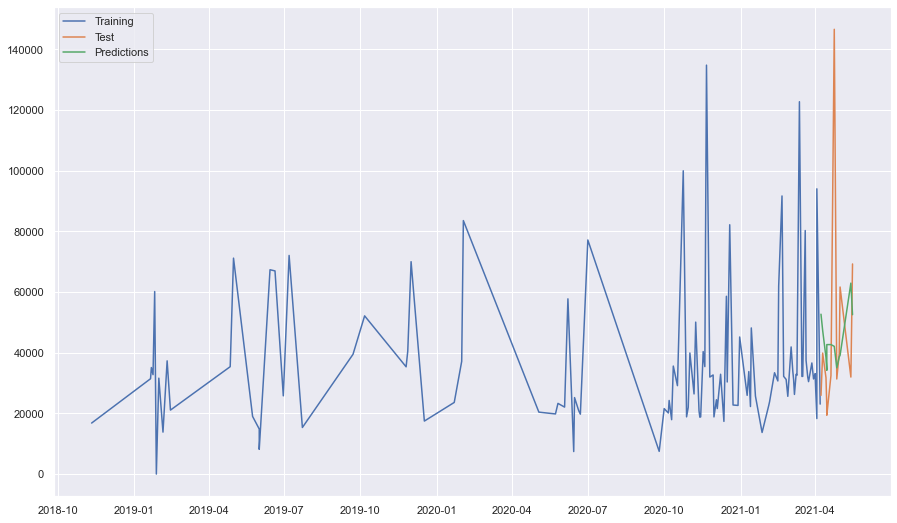

In [129]:
plt.figure(figsize=(15,9))
plt.plot(ride_train, label = 'Training')
plt.plot(ride_test, label = 'Test')
plt.plot(ride_prediction, label = 'Predictions')
plt.legend();

In [131]:

ride_yvspred = pd.DataFrame({
    'y_test': ride_test,
    'pred': ride_prediction['distance_predict']
})

ride_yvspred.head()

,y_test,pred
start_date,,
2021-04-08,25946.5,52700.905658
2021-04-10,39884.2,47368.129752
2021-04-14,31791.7,38478.385122
2021-04-15,22206.4,34198.597022
2021-04-15,19396.2,42679.725474
